# XGBoost trainer
This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api"s.

## Steps
1. generate an xgboost model configuration by selecting one of 5 available types (currently, only classification implemented)
2. get a sample of data from a data source (random rows, consecutive rows, or the entire dataset, custom sample)
3. split the data into train, validation, and test sets (WIP, this will be parametrized cross-validator)  
4. train the model using xgboost in one of its flavours (dask, gpu, mpi...)
5. dump the model
6. evaluate the model

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
from mlrun.mlutils.data import get_sample, get_splits
from mlrun.mlutils.models import gen_sklearn_model, eval_model_v2
from mlrun.utils.helpers import create_class

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

from cloudpickle import dumps
import pandas as pd
import os
from typing import Union

## Generate a XGBoost model

generate a model config using the xgboost's sklearn api

In [4]:
def _gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API.
    
    Input can either be a predefined json model configuration or one
    of the five xgboost model types: "classifier", "regressor", "ranker",
    "rf_classifier", or "rf_regressor".
    
    In either case one can pass in a params dict to modify defaults values.
    
    Based on `mlutils.models.gen_sklearn_model`, see the function
    `sklearn_classifier` in this repository.
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: class init parameters
    """
    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBRanker",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type.endswith("json"):
        model_config = model_type
    elif model_type in mtypes.keys():
        model_config = mtypes[model_type]
    else:
        raise Exception("unrecognized model type, see help documentation")

    return gen_sklearn_model(model_config, xgb_params)

## Train

In [5]:
def train_model(
    context: MLClientCtx,
    model_type: str,
    dataset: Union[DataItem, pd.core.frame.DataFrame],
    label_column: str = "labels",
    encode_cols: dict = {},
    sample: int = -1,
    imbal_vec = [],
    test_size: float = 0.25,
    valid_size: float = 0.75,
    random_state: int = 1,
    models_dest: str = "models",
    plots_dest: str = "plots",
    eval_metrics: list= ["error", "auc"],
    file_ext: str = "parquet",
    test_set: str = "test_set"
) -> None:
    """train an xgboost model.
    
    Note on imabalanced data:  the `imbal_vec` parameter represents the measured
    class representations in the sample and can be used as a first step in tuning
    an XGBoost model.  This isn't a hyperparamter, merely an estimate that should
    be set as 'constant' throughout tuning process.
    
    :param context:           the function context
    :param model_type:        the model type to train, "classifier", "regressor"...
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param imbal_vec:         ([]) vector of class weights seen in sample
    :param test_size:         (0.05) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param eval_metrics:      (["error", "auc"]) learning curve metrics
    :param file_ext:          format for test_set_key hold out data
    :param test-set:          (test_set) key of held out data in artifact store
    """
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, valid_size, random_state)
    
    # save test data
    context.log_dataset(test_set, df=pd.concat([xtest, ytest], axis=1), format=file_ext, index=False)

    # get model config
    model_config = _gen_xgb_model(model_type, context.parameters.items())

    # create model instance
    XGBBoostClass = create_class(model_config["META"]["class"])
    model = XGBBoostClass(**model_config["CLASS"])

    # update the model config with training data and callbacks
    model_config["FIT"].update({"X": xtrain, 
                                "y": ytrain.values,
                                "eval_set":[(xtrain, ytrain), (xvalid, yvalid)],
                                "eval_metric": eval_metrics})

    # run the fit
    model.fit(**model_config["FIT"])

    # evaluate model
    eval_metrics = eval_model_v2(context, xvalid, yvalid, model)
    
    model_bin = dumps(model)
    context.log_model("model", body=model_bin,
                      artifact_path=os.path.join(context.artifact_path, models_dest),
                      #model_dir=models_dest, 
                      model_file="model.pkl")

In [6]:
# nuclio: end-code

## Import Function

In [3]:
from mlrun import import_function
from mlrun.platforms.other import auto_mount

GPU = False


fn = import_function("hub://xgb_trainer")
fn.image = "mlrun/ml-models" if not GPU else "mlrun/ml-models-gpu"
fn.apply(auto_mount())

[mlrun] 2020-07-06 15:43:06,061 function spec saved to path: function.yaml


## Test Function

### Generate test data

In [8]:
from mlrun import import_function, mlconf, NewTask
from mlrun.platforms.other import auto_mount

gen_data = import_function("hub://gen_class_data", "gendata")
gen_data.apply(auto_mount())

gen_params = {
    "name":        "tasks generate classification data", 
    "params" : {
        "n_samples"   : 10_000,
        "m_features"  : 5,
        "k_classes"   : 2,
        "weight"      : [0.5, 0.5],
        "sk_params"   : {"n_informative": 2},
        "file_ext"    : "csv"}}


gen_data.run(NewTask(**gen_params), artifact_path=mlconf.artifact_path+"/xgb")

[mlrun] 2020-06-14 10:39:49,413 starting run tasks generate classification data uid=00dc12c4e979447698fb1e6f17efa469  -> http://mlrun-api:8080
[mlrun] 2020-06-14 10:39:49,533 Job is running in the background, pod: tasks-generate-classification-data-ncbd8
[mlrun] 2020-06-14 10:39:53,013 starting local run: main.py # gen_class_data
[mlrun] 2020-06-14 10:39:53,565 log artifact classifier-data at /User/artifacts/xgb/classifier-data.csv, size: 998700, db: Y

[mlrun] 2020-06-14 10:39:53,583 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...17efa469,0,Jun 14 10:39:53,completed,tasks generate classification data,v3io_user=adminkind=jobowner=adminhost=tasks-generate-classification-data-ncbd8,,"n_samples=10000m_features=5k_classes=2weight=[0.5, 0.5]sk_params={'n_informative': 2}file_ext=csv",,classifier-data


to track results use .show() or .logs() or in CLI: 
!mlrun get run 00dc12c4e979447698fb1e6f17efa469 --project default , !mlrun logs 00dc12c4e979447698fb1e6f17efa469 --project default
[mlrun] 2020-06-14 10:39:55,676 run executed, status=completed


### Setup XGBoost Parameters

In [9]:
task_params = {
    "name" : "tasks xgb cpu trainer",
    "params" : {
        "model_type"              : "classifier",
        "CLASS_tree_method"       : "hist" if not gpus else "gpu_hist",
        "CLASS_objective"         : "binary:logistic",
        "CLASS_booster"           : "gbtree",
        "FIT_verbose"             : 0,
        "label_column"            : "labels"}}

### run locally

[mlrun] 2020-06-14 10:39:55,699 starting run tasks xgb cpu trainer uid=e02fc9ca13674195ae6cb1d79e10e372  -> http://mlrun-api:8080
[mlrun] 2020-06-14 10:39:55,858 log artifact test_set at /User/artifacts/test_set.parquet, size: 123488, db: Y
[mlrun] 2020-06-14 10:39:56,857 log artifact probability-calibration at /User/artifacts/plots/probability-calibration.html, size: 25986, db: N
[mlrun] 2020-06-14 10:39:57,038 log artifact confusion-matrix at /User/artifacts/plots/confusion-matrix.html, size: 10209, db: N
[mlrun] 2020-06-14 10:39:57,251 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 8417, db: N
[mlrun] 2020-06-14 10:39:57,369 log artifact precision-recall-binary at /User/artifacts/plots/precision-recall-binary.html, size: 16425, db: N
[mlrun] 2020-06-14 10:39:57,501 log artifact roc-binary at /User/artifacts/plots/roc-binary.html, size: 19805, db: N
[mlrun] 2020-06-14 10:39:57,537 log artifact model at /User/artifacts/models/, size: 127681, 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...9e10e372,0,Jun 14 10:39:55,completed,tasks xgb cpu trainer,v3io_user=adminkind=handlerowner=adminhost=jupyter-7b44c8d958-kklf7,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0label_column=labels,accuracy=0.9548444444444445test-error=0.04515555555555555rocauc=0.9803470988703957brier_score=0.03883511625461902f1-score=0.9545779685264664precision_score=0.9663287472845764recall_score=0.9431095406360424,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run e02fc9ca13674195ae6cb1d79e10e372 --project default , !mlrun logs e02fc9ca13674195ae6cb1d79e10e372 --project default
[mlrun] 2020-06-14 10:39:57,597 run executed, status=completed


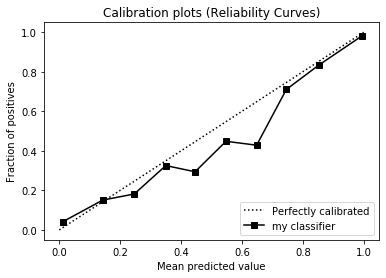

<Figure size 432x288 with 0 Axes>

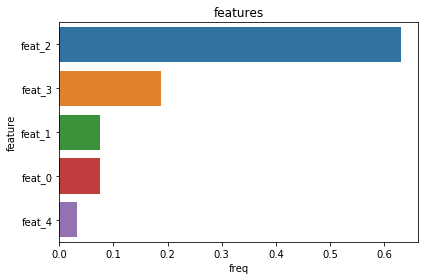

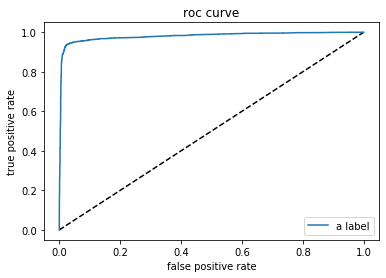

In [10]:
from mlrun import run_local, NewTask, mlconf

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : mlconf.artifact_path+"/xgb/classifier-data.csv"})

### run remotely

In [11]:
run = fn.run(
    NewTask(**task_params),
    inputs={"dataset"  : mlconf.artifact_path+"/xgb/classifier-data.csv"},
    artifact_path=mlconf.artifact_path+"/xgb")

[mlrun] 2020-06-14 10:39:57,945 starting run tasks xgb cpu trainer uid=1af3790534694ceab73b3c364771578a  -> http://mlrun-api:8080
[mlrun] 2020-06-14 10:39:58,090 Job is running in the background, pod: tasks-xgb-cpu-trainer-4t9sb
[mlrun] 2020-06-14 10:40:01,567 starting local run: main.py # train_model
[mlrun] 2020-06-14 10:40:02,461 log artifact test_set at /User/artifacts/xgb/test_set.parquet, size: 123680, db: Y
[mlrun] 2020-06-14 10:40:03,682 log artifact probability-calibration at /User/artifacts/xgb/plots/probability-calibration.html, size: 50142, db: N
[mlrun] 2020-06-14 10:40:03,817 log artifact confusion-matrix at /User/artifacts/xgb/plots/confusion-matrix.html, size: 18905, db: N
[mlrun] 2020-06-14 10:40:04,066 log artifact feature-importances at /User/artifacts/xgb/plots/feature-importances.html, size: 18029, db: N
[mlrun] 2020-06-14 10:40:04,289 log artifact precision-recall-binary at /User/artifacts/xgb/plots/precision-recall-binary.html, size: 30789, db: N
[mlrun] 2020-06-

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...4771578a,0,Jun 14 10:40:02,completed,tasks xgb cpu trainer,v3io_user=adminkind=jobowner=adminhost=tasks-xgb-cpu-trainer-4t9sb,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0label_column=labels,accuracy=0.9552test-error=0.0448rocauc=0.9799618829687036brier_score=0.038984999293145965f1-score=0.954983922829582precision_score=0.965679190751445recall_score=0.9445229681978798,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1af3790534694ceab73b3c364771578a --project default , !mlrun logs 1af3790534694ceab73b3c364771578a --project default
[mlrun] 2020-06-14 10:40:07,313 run executed, status=completed
